In [1]:
# dataset
FILENAME = "compounds_ms2structures"

# similarity calculation
MORGAN_RADIUS=9
FINGERPRINT_BITS=4096

# analogue selection
NUM_QUERIES = 1000
GROUP_SIZE=10
SIMILARITY_RANGE=(0.7, 0.9999)
NO_OVERLAP=False
RANDOM_SELECT = True   # Set to false to iterate through the dataset sequentially. Might be be better for high similarity selections.
SEED=42

## Init

In [2]:
import os
import random
import pandas as pd
import numpy as np
import numba
from numba import prange
from tqdm.notebook import tqdm

from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFingerprintGenerator, SmilesMolSupplier

from fingerprint_computation import FingerprintGenerator, compute_fingerprints_from_smiles
from ms_chemical_space_explorer.similarity_maps import generate_mol, get_similarity_map_weights, FingerprintFunction

path = os.path.join( "data", "datasets", FILENAME + ".csv")
fingerprints_file = os.path.join("data", "group_similarity", f"{FILENAME}_fingerprints_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
sim_matrix_file = os.path.join("data", "group_similarity", f"{FILENAME}_ruzicka_similarities_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.npy")
df_file = os.path.join("data", "group_similarity", "benchmarks", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{GROUP_SIZE}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")


# if FILENAME == "compounds_ms2structures":
#     supplier = SmilesMolSupplier(path, delimiter=',', titleLine=True, smilesColumn=1, nameColumn=0)
# elif FILENAME == "biostructures_combined":
#     supplier = SmilesMolSupplier(path, titleLine=True, nameColumn=0)

compounds = pd.read_csv(path)
compounds.head()

,inchikey,smiles,mass,cf_class,cf_subclass,cf_superclass,formula,npc_class_results,npc_pathway_results,npc_superclass_results
0,AAAQFGUYHFJNHI,CCNC(=O)C[C@H]1C2=NN=C(N2C3=C(C=C(C=C3)OC)C(=N...,423.146204,Benzodiazepines,"1,4-benzodiazepines",Organoheterocyclic compounds,C22H22ClN5O2,NaN,Alkaloids,NaN
1,AABFWJDLCCDJJN,COC1=CC2=C(C=C1)NC3=C2C=CN=C3C4=CC=CC5=CC=CC=C54,324.126264,Harmala alkaloids,NaN,Alkaloids and derivatives,C22H16N2O,Carboline alkaloids,Alkaloids,Tryptophan alkaloids
2,AABILZKQMVKFHP,C/C=C(/C)\C(=O)O[C@H]1CC[N+]2([C@@H]1C(=CC2)CO...,427.220624,NaN,NaN,Alkaloids and derivatives,C21H33NO8,Pyrrolizidine alkaloids,Alkaloids,Ornithine alkaloids
3,AABUHSBGEIUSRJ,CC(=O)NC1=CC=C(C=C1)NC(=O)C=CC2=CC=CC=C2,280.120724,Cinnamic acids and derivatives,Cinnamic acid amides,Phenylpropanoids and polyketides,C17H16N2O2,Cinnamic acid amides,Shikimates and Phenylpropanoids,Phenylpropanoids (C6-C3)
4,AABUKWVVUWBZCS,C1=CC=C(C=C1)C2=C(C(=O)OC3=C2C=CC(=C3)O)C4=CC=...,314.094724,Neoflavonoids,Neoflavones,Phenylpropanoids and polyketides,C21H14O3,Neoflavonoids,Shikimates and Phenylpropanoids,Flavonoids


In [3]:
compounds.smiles[12]

'CCCCCCCCCCCCCCCCCCCC(=O)N[C@@H](COP(=O)([O-])OCC[N+](C)(C)C)[C@@H](/C=C/CCCCCCCCCCCCC)O'

## Fingerprints & Similarities

In [4]:
# code taken from https://github.com/florian-huber/molecular_fingerprint_comparisons
@numba.njit
def ruzicka_similarity(A, B):
    """
    Calculate the Ruzicka similarity between two count vectors.
    
    Parameters:
    A (array-like): First count vector.
    B (array-like): Second count vector.
    
    Returns:
    float: Ruzicka similarity.
    """
    
    min_sum = np.sum(np.minimum(A, B))
    max_sum = np.sum(np.maximum(A, B))
    
    return min_sum / max_sum


@numba.jit(nopython=True, fastmath=True, parallel=True)
def ruzicka_similarity_matrix(references: np.ndarray, queries: np.ndarray) -> np.ndarray:
    """Returns matrix of Ruzicka similarity between all-vs-all vectors of references and queries.

    Parameters
    ----------
    references
        Reference vectors as 2D numpy array. Expects that vector_i corresponds to
        references[i, :].
    queries
        Query vectors as 2D numpy array. Expects that vector_i corresponds to
        queries[i, :].

    Returns
    -------
    scores
        Matrix of all-vs-all similarity scores. scores[i, j] will contain the score
        between the vectors references[i, :] and queries[j, :].
    """
    assert references.shape[1] == queries.shape[1], "Vector sizes do not match!"

    size1 = references.shape[0]
    size2 = queries.shape[0]
    scores = np.zeros((size1, size2)) #, dtype=np.float32)
    for i in prange(size1):
        for j in range(size2):
            scores[i, j] = ruzicka_similarity(references[i, :], queries[j, :])
    return scores


def compute_similarity_matrix(fingerprints, sim_matrix_file):
    similarities_morgan_count = ruzicka_similarity_matrix(fingerprints, fingerprints)
    np.save(sim_matrix_file, similarities_morgan_count.astype(np.float32)) # big one ~5GB
    return np.load(sim_matrix_file, mmap_mode ='r')

In [5]:
try:
    fingerprints = np.load(fingerprints_file, mmap_mode ='r')
    print(f"Found {fingerprints_file}\nLoading fingerprints.")
except FileNotFoundError:
    print(f"File not found: {fingerprints_file}\nRunning fingerprint generation.")
    # fingerprint generation
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=MORGAN_RADIUS, fpSize=FINGERPRINT_BITS)
    fingerprints = compute_fingerprints_from_smiles(compounds.smiles, fpgen, count=True, sparse=False, progress_bar=True)
    np.save(fingerprints_file, fingerprints.astype(np.float32))
    fingerprints = np.load(fingerprints_file, mmap_mode ='r')

# sim matrix generation
try:
    sim_matrix = np.load(sim_matrix_file, mmap_mode ='r')
    print(f"Found {sim_matrix_file}\nLoading similarity matrix.")
except FileNotFoundError:
    print(f"File not found: {sim_matrix_file}\nRunning similarity computations.")
    %time
    sim_matrix = compute_similarity_matrix(fingerprints, sim_matrix_file)

print(fingerprints.shape, sim_matrix.shape)

Found data\group_similarity\compounds_ms2structures_fingerprints_morgan9_4096bits.npy
Loading fingerprints.
Found data\group_similarity\compounds_ms2structures_ruzicka_similarities_morgan9_4096bits.npy
Loading similarity matrix.
(37811, 4096) (37811, 37811)


In [6]:
sim_matrix[:10]

memmap([[1.        , 0.14035088, 0.05179283, ..., 0.13265306, 0.09448819,
         0.06993007],
        [0.14035088, 1.        , 0.03361345, ..., 0.17919075, 0.06557377,
         0.03597122],
        [0.05179283, 0.03361345, 1.        , ..., 0.04      , 0.08196721,
         0.10188679],
        ...,
        [0.04320988, 0.02515723, 0.10538117, ..., 0.01576577, 0.06289309,
         0.10082304],
        [0.05952381, 0.0738255 , 0.01863354, ..., 0.07964602, 0.05325444,
         0.02487562],
        [0.02469136, 0.01534527, 0.05526316, ..., 0.00842697, 0.02469136,
         0.04976304]], dtype=float32)

## Analogue Selection

In [7]:
def select_analogue_groups(similarity_matrix, num_queries=10, random_select=False, group_size=30, sim_range=(0.8, 0.9999), no_overlap=True, seed=42, print_mean_similarity=False):
    random.seed(seed)
    analogue_df = pd.DataFrame(columns=["query_id", "analogue_ids"])
    used_indices =[]
    used_queries = []
    
    if random_select:
        query_index = random.randint(0, len(similarity_matrix) - 1)
    else:
        query_index = 0
    
    for i in tqdm(range(len(similarity_matrix)), desc="Selecting analogue groups"):
        # Select a random query index from the similarity matrix

        while random_select and query_index in used_queries:
            query_index = random.randint(0, len(similarity_matrix) - 1)
        
        if not random_select:
            query_index = i
        
        similar_indices = np.nonzero((similarity_matrix[query_index] >= sim_range[0]) & (similarity_matrix[query_index] <= sim_range[1]))[0]
        # remove already used ids from similar_indices
        similar_indices = [idx for idx in similar_indices if idx not in used_indices]
        # check if group size is large enough
        if len(similar_indices) >= group_size:
            if print_mean_similarity:
                mean_similarity = np.mean(similarity_matrix[query_index][similar_indices])
                print(f"Index {query_index}: Found {len(similar_indices)} similar compounds with mean similarity {mean_similarity:.3f}. Picking {group_size} random matches.")
            
            random_matches = random.sample(list(similar_indices), group_size)
            random_matches.sort(key=lambda x: similarity_matrix[query_index][x], reverse=True)
            
            analogue_df.loc[len(analogue_df)] = [query_index, random_matches]
            if no_overlap:
                used_indices.append(query_index)
                used_indices.extend(random_matches)
        
        used_queries.append(query_index)
        
        if len(analogue_df) >= num_queries:
            break
        
    analogue_df.set_index("query_id", inplace=True)
    if len(analogue_df) < num_queries:
        print(f"Found only {len(analogue_df)} analogue groups for given parameters:\nnum_queries={num_queries}, random_select={random_select}, group_size={group_size}, sim_range={sim_range}, no_overlap={no_overlap}.")
    return analogue_df


def str_to_list_of_ints(series):
    return [int(x) for x in series.strip("[]").split(",") if x.strip().isdigit()]


def get_analogue_groups_df(df_file, num_queries, random_select, group_size, sim_range, no_overlap, seed, morgan_radius, fpSize):
    try:
        analogue_df = pd.read_csv(df_file, index_col=0)
        analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nLoaded {len(analogue_df)} analogue groups.")
    except FileNotFoundError:
        print(f"File not found: {df_file}\nRunning the analogue group selection.")
        # analogue group selection
        analogue_df = select_analogue_groups(sim_matrix,
                                             num_queries=num_queries,
                                             random_select=random_select,
                                             group_size=group_size,
                                             sim_range=sim_range,
                                             no_overlap=no_overlap, 
                                             seed=seed,
                                            )#print_mean_similarity=True)
        analogue_df.to_csv(df_file)
        print(f"{len(analogue_df)} analogue groups saved to {df_file}.")
    return analogue_df

## Benchmark

In [8]:
def off_diagonal_mean(matrix):
    n = matrix.shape[0]
    # Create mask for off-diagonal elements
    mask = ~np.eye(n, dtype=bool)
    return matrix[mask].mean()


def get_group_sized_benchmark_df_file(df_file, analogue_df, morgan_radius, fpSize, group_size):
    try:
        analogue_df = pd.read_csv(df_file, index_col=0)
        analogue_df["analogue_ids"] = analogue_df["analogue_ids"].apply(str_to_list_of_ints)
        print(f"Found {df_file}\nTrying to access benchmark columns.\nExisting columns: {analogue_df.columns.tolist()}")
        query_sim= analogue_df[:1].query_sim
        query_mean_weights=analogue_df[:1].query_mean_weights
        group_sim=analogue_df[:1].group_sim
        sgs=analogue_df[:1].sgs
        sgs_score=analogue_df[:1].sgs_score
        print(f"Benchmark found! Loaded benchmark for {len(analogue_df)} queries.")
    except Exception as e:
        print(f"Benchmark not found: {df_file}\nRunning the benchmark dataframe generation.")
        # generate benchmark dataframe
        fp_function = FingerprintFunction(fingerprint="MORGAN")
        fp_function.fp_type = "count"
        fp_function.morgan_radius = morgan_radius
        fp_function.nbits = fpSize

        for query_id, row in tqdm(analogue_df.iterrows(), desc="Processing queries", total=len(analogue_df)):
            analogue_ids = [int(x) for x in row["analogue_ids"]][:group_size]
            query = generate_mol(compounds.smiles[query_id])
            
            analogues = {}
            query_sims = []
            stacked_mean_weights = []
            query_mean_weights = []
            query_scaled_inverted_differnces = []
            for ref_id in analogue_ids:
                # gather ruzicka similarity of analogue vs query
                query_sims.append(sim_matrix[query_id][ref_id])
                
                # generate the reference molecule
                if ref_id in analogues:
                    ref_analogue = analogues[ref_id]
                else:
                    ref_analogue = generate_mol(compounds.smiles[ref_id])
                    analogues[ref_id] = ref_analogue
                
                # create array for stacked weights
                stacked_atomic_weights = [0] * ref_analogue.GetNumAtoms()
                
                # compute the group similarity map weights
                for probe_id in analogue_ids:#tqdm(analogue_ids, desc=f"Computing weights for weights for analogue {ref_id}", leave=False):
                    if ref_id == probe_id:
                        continue
                    
                    if probe_id in analogues:
                        probe_analogue = analogues[probe_id]
                    else:
                        probe_analogue = generate_mol(compounds.smiles[probe_id])
                        analogues[probe_id] = probe_analogue

                    # extract and standardize similarity weights for the reference molecule
                    ref_sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(probe_analogue, ref_analogue, fp_function.get_function, metric=DataStructs.TanimotoSimilarity) #this is the bottle neck
                    #print(f"Getting weights took {(pd.Timestamp.now() - getting_weights_start).total_seconds():.4f} seconds")

                    # stack the weights
                    stacked_atomic_weights = [stacked_atomic_weights[i] + ref_sim_weights[i] for i in range(ref_analogue.GetNumAtoms())]
                # Standardize the stacked weights
                stacked_atomic_weights, _ = SimilarityMaps.GetStandardizedWeights(stacked_atomic_weights)
                stacked_mean_weights.append(sum(stacked_atomic_weights) / len(stacked_atomic_weights))
                
                # compute the similarity map weights against the query molecule
                query_atomic_weights = get_similarity_map_weights(ref_analogue, query, fp_function)
                query_mean_weights.append(sum(query_atomic_weights) / len(query_atomic_weights))
                
                # calculate absolute weight difference for each atom against the query
                query_abs_differences = ([abs(stacked_atomic_weights[i] - query_atomic_weights[i]) for i in range(len(stacked_atomic_weights))])
                query_mean_difference = sum(query_abs_differences) / len(query_abs_differences)
                
                # scale and invert the mean absolute difference to get a similarity score
                query_scaled_inverted_differnce = 1 - (query_mean_difference * 0.5)
                query_scaled_inverted_differnces.append(query_scaled_inverted_differnce)
            # --- gather all similarity metrics ---
            # mean ruzicka similarity of analogue vs query ruzicka similaities
            analogue_df.loc[query_id, "query_sim"] = np.mean(query_sims)
            
            #  mean of the means of query atomic weights
            unscaled_query_mean_weights = np.mean(query_mean_weights)  # range [-1, 1]
            analogue_df.loc[query_id, "query_mean_weights"] = (unscaled_query_mean_weights + 1) / 2   # range [0, 1]
            
            # mean of all-vs-all analogue ruzicka similarities
            fp_group_sim_matrix = ruzicka_similarity_matrix(fingerprints[analogue_ids], fingerprints[analogue_ids])
            group_sim = off_diagonal_mean(fp_group_sim_matrix)
            analogue_df.loc[query_id, "group_sim"] = group_sim
            
            # mean of the means of stacked atomic weights of all-vs-all analogue similarity maps
            unscaled_sgs = np.mean(stacked_mean_weights)                # range [-1, 1]
            analogue_df.loc[query_id, "sgs"] = (unscaled_sgs + 1) / 2   # range [0, 1]
            
            # scaled and inverted mean of the means of the absolute differences between atomic stacked weights and atomic query weights
            sgs_score = (sum(query_scaled_inverted_differnces) / len(query_scaled_inverted_differnces))
            analogue_df.loc[query_id, "sgs_score"] = sgs_score

        analogue_df.to_csv(df_file)
        print(f"Saved {len(analogue_df)} queries to {df_file}.")
    return analogue_df

In [9]:
max_group_size = GROUP_SIZE + 1
all_dfs = []
big_df = get_analogue_groups_df(df_file, NUM_QUERIES, RANDOM_SELECT, GROUP_SIZE, SIMILARITY_RANGE, NO_OVERLAP, SEED, MORGAN_RADIUS, FINGERPRINT_BITS)

for group_size in tqdm(range(2, max_group_size), desc="Benchmarking varying group sizes..."):
    group_sized_df_file = os.path.join("data", "group_similarity", "benchmarks", f"{FILENAME}_benchmark_num_queries{NUM_QUERIES}_random{int(RANDOM_SELECT)}_size{group_size}_range{SIMILARITY_RANGE}_no_overlap{int(NO_OVERLAP)}_seed{SEED}_morgan{MORGAN_RADIUS}_{FINGERPRINT_BITS}bits.csv")
    analogue_df = get_group_sized_benchmark_df_file(group_sized_df_file, big_df, MORGAN_RADIUS, FINGERPRINT_BITS, group_size)
    analogue_df["group_sim_diff"] = abs(analogue_df.sgs - analogue_df.group_sim)
    print(f"-------- Group size {group_size}: Entries with group_sim_diff greater than 0.05 = {len(analogue_df[analogue_df.group_sim_diff > 0.05])} --------")
    all_dfs.append(analogue_df)

Found data\group_similarity\benchmarks\compounds_ms2structures_benchmark_num_queries1000_random1_size10_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Loaded 1000 analogue groups.


Benchmarking varying group sizes...:   0%|          | 0/9 [00:00<?, ?it/s]

Found data\group_similarity\benchmarks\compounds_ms2structures_benchmark_num_queries1000_random1_size2_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['analogue_ids', 'query_sim', 'query_mean_weights', 'group_sim', 'sgs', 'sgs_score']
Benchmark found! Loaded benchmark for 1000 queries.
-------- Group size 2: Entries with group_sim_diff greater than 0.05 = 661 --------
Found data\group_similarity\benchmarks\compounds_ms2structures_benchmark_num_queries1000_random1_size3_range(0.7, 0.9999)_no_overlap0_seed42_morgan9_4096bits.csv
Trying to access benchmark columns.
Existing columns: ['analogue_ids', 'query_sim', 'query_mean_weights', 'group_sim', 'sgs', 'sgs_score', 'group_sim_diff']
Benchmark found! Loaded benchmark for 1000 queries.
-------- Group size 3: Entries with group_sim_diff greater than 0.05 = 581 --------
Found data\group_similarity\benchmarks\compounds_ms2structures_benchmark_num_queries1000_random1_size4_range

xmin = min(analogue_df.sgs.min(), analogue_df.group_sim.min())
xmax = max(analogue_df.sgs.max(), analogue_df.group_sim.max())

In [10]:
all_dfs[7].describe()

,query_sim,query_mean_weights,group_sim,sgs,sgs_score,group_sim_diff
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.793131,0.747929,0.745546,0.740822,0.958326,0.042332
std,0.034291,0.035027,0.048446,0.031687,0.015734,0.028972
min,0.718772,0.612737,0.632510,0.616472,0.900436,0.000149
25%,0.768125,0.725581,0.709116,0.722768,0.949037,0.018908
50%,0.789785,0.749804,0.741046,0.738634,0.958760,0.038572
75%,0.813674,0.772235,0.778266,0.763578,0.968393,0.061053
max,0.893343,0.853313,0.908490,0.820470,0.995764,0.147985


In [11]:
all_dfs[0].describe()

,query_sim,query_mean_weights,group_sim,sgs,sgs_score,group_sim_diff
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.880119,0.779173,0.840134,0.763786,0.960274,0.085787
std,0.052303,0.040087,0.083856,0.041345,0.027135,0.056424
min,0.736403,0.613231,0.570000,0.609292,0.828086,0.000014
25%,0.845289,0.752553,0.777394,0.739814,0.947090,0.033686
50%,0.885096,0.776645,0.849372,0.765834,0.967985,0.080881
75%,0.923251,0.809053,0.911140,0.791094,0.977828,0.133342
max,0.975182,0.875159,0.975845,0.862882,0.999800,0.228994


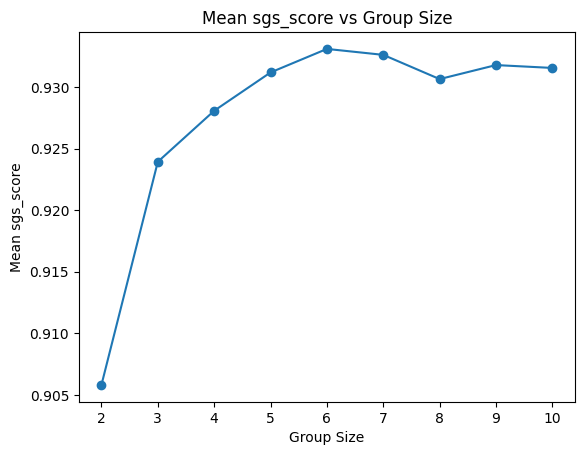

In [49]:
# plot the mean query_sim of every dataframe in all_dfs
import matplotlib.pyplot as plt

column = "sgs_score"
means = [df[column].quantile(0.05) for df in all_dfs]
plt.plot(range(2, max_group_size), means, marker='o')
# --- IGNORE ---
plt.xlabel("Group Size")
plt.ylabel("Mean " + column)
plt.title("Mean " + column + " vs Group Size")
plt.show()


In [29]:
all_dfs[6][column].quantile(0.05)

0.9306451950809949

In [13]:
y_column = "sgs"
x_column = "group_sim"
group_size_a = 10
group_size_b = 2
x_range = [0.5, 0.9]
y_range = [0.3, 1]

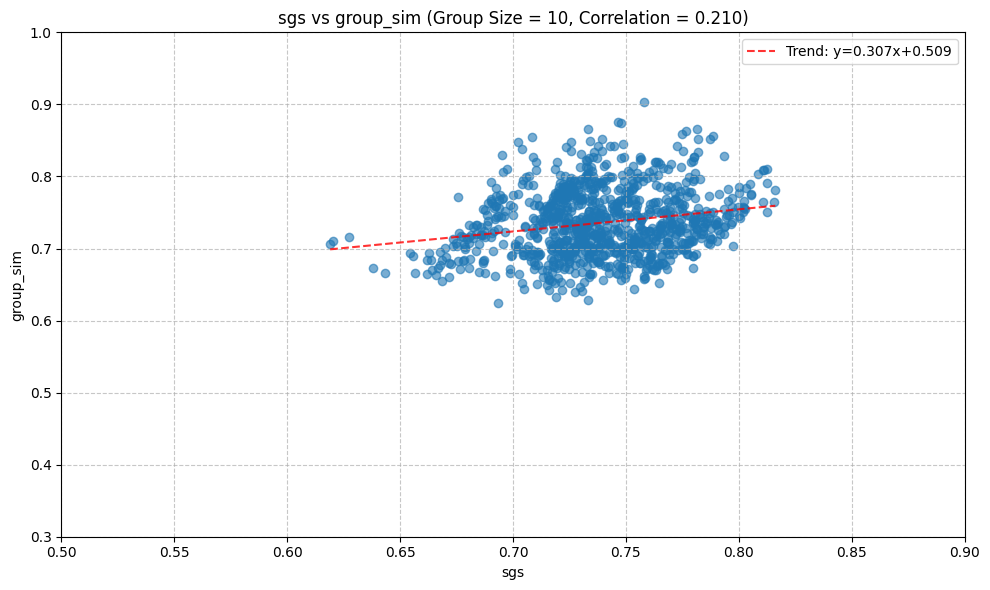

In [14]:
import numpy as np

group_size = group_size_a
# Get the first dataframe (group size = 2)
df = all_dfs[group_size - 2]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
scatter = ax.scatter(df[y_column], df[x_column], alpha=0.6)

# Add trend line
z = np.polyfit(df[y_column], df[x_column], 1)
p = np.poly1d(z)
ax.plot(df[y_column].sort_values(), p(df[y_column].sort_values()), 
    "r--", alpha=0.8, label=f"Trend: y={z[0]:.3f}x+{z[1]:.3f}")

# Calculate correlation coefficient
correlation = df[y_column].corr(df[x_column])

# Add labels and title
ax.set_xlabel(y_column)
ax.set_ylabel(x_column)
ax.set_title(f'{y_column} vs {x_column} (Group Size = {group_size}, Correlation = {correlation:.3f})')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Set axis limits to [0, 1]
ax.set_xlim(x_range)
ax.set_ylim(y_range)

plt.tight_layout()
plt.show()

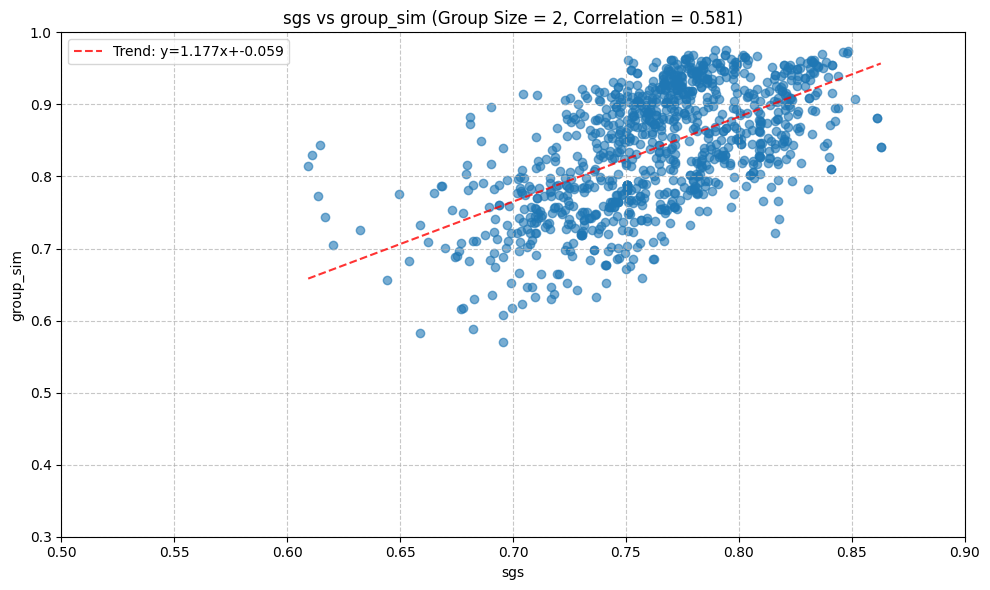

In [15]:
import numpy as np

group_size = group_size_b
# Get the first dataframe (group size = 2)
df = all_dfs[group_size - 2]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
scatter = ax.scatter(df[y_column], df[x_column], alpha=0.6)

# Add trend line
z = np.polyfit(df[y_column], df[x_column], 1)
p = np.poly1d(z)
ax.plot(df[y_column].sort_values(), p(df[y_column].sort_values()), 
    "r--", alpha=0.8, label=f"Trend: y={z[0]:.3f}x+{z[1]:.3f}")

# Calculate correlation coefficient
correlation = df[y_column].corr(df[x_column])

# Add labels and title
ax.set_xlabel(y_column)
ax.set_ylabel(x_column)
ax.set_title(f'{y_column} vs {x_column} (Group Size = {group_size}, Correlation = {correlation:.3f})')
ax.grid(True, linestyle='--', alpha=0.7)
ax.legend()

# Set axis limits to [0, 1]
ax.set_xlim(x_range)
ax.set_ylim(y_range)

plt.tight_layout()
plt.show()

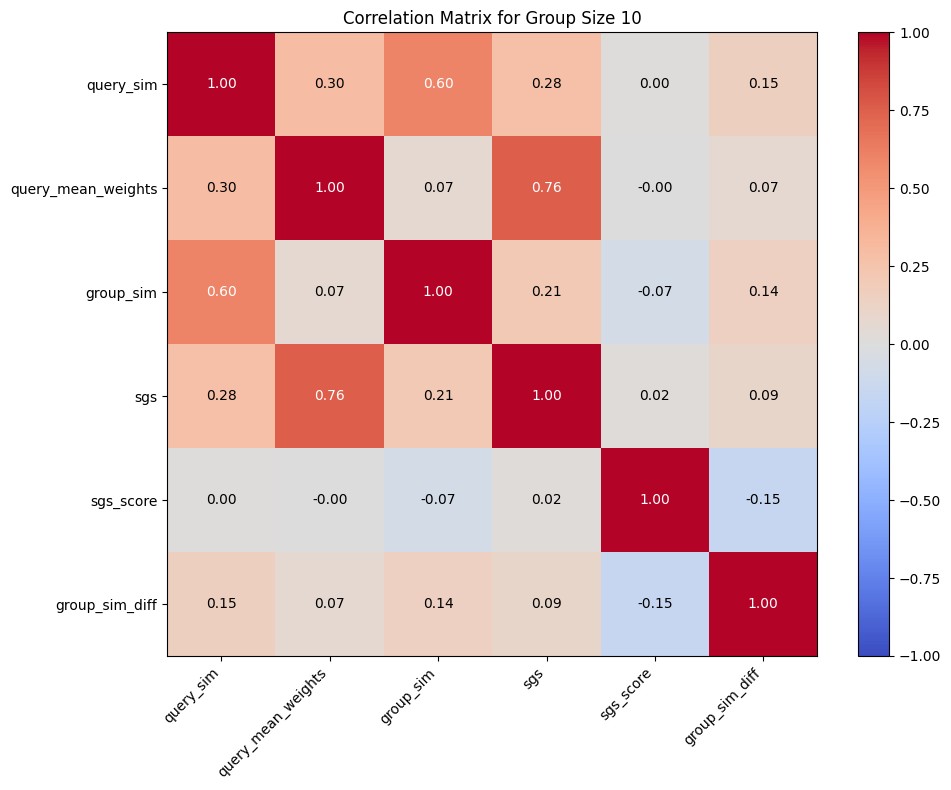

In [16]:
import matplotlib.pyplot as plt

df_id = 8

# Create correlation matrix heatmap without seaborn
fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = all_dfs[df_id].drop(columns=["analogue_ids"]).corr()

# Create heatmap using matplotlib
im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Add colorbar
plt.colorbar(im)

# Set ticks and labels
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix.index)

# Add correlation values as text
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                      ha="center", va="center", color="black" if abs(corr_matrix.iloc[i, j]) < 0.5 else "white")

plt.title(f"Correlation Matrix for Group Size {df_id + 2}")
plt.tight_layout()
plt.show()

C:\Users\kevin\AppData\Local\Temp\ipykernel_27392\4257552675.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevin\AppData\Local\Temp\ipykernel_27392\4257552675.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevin\AppData\Local\Temp\ipykernel_27392\4257552675.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevin\AppData\Local\Temp\ipykernel_27392\4257552675.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevin\AppData\Local\Temp\ipykernel_27392\4257552675.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevin\AppData\Local\Temp\ipykernel_27392\4257552675.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevin\AppData\Local\Temp\ipykernel_27392\4257552675.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\kevi

Animation saved as correlation_matrices_by_group_size.gif


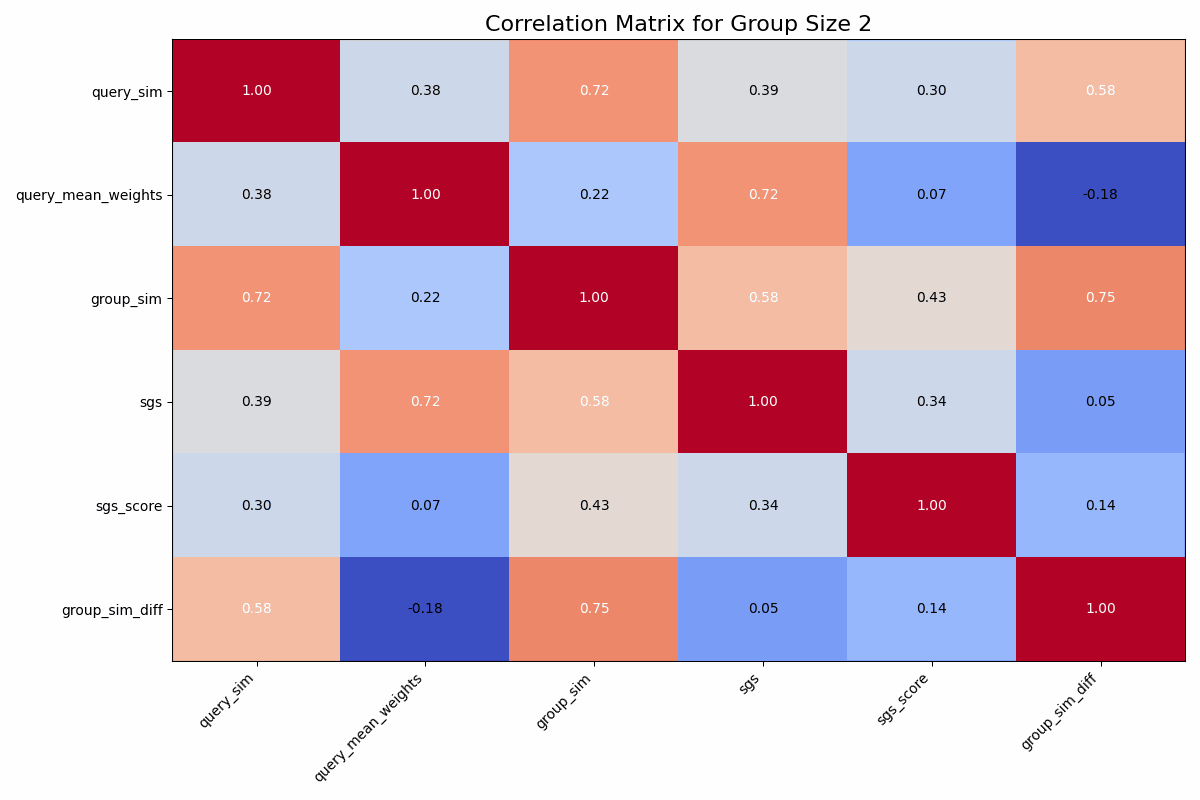

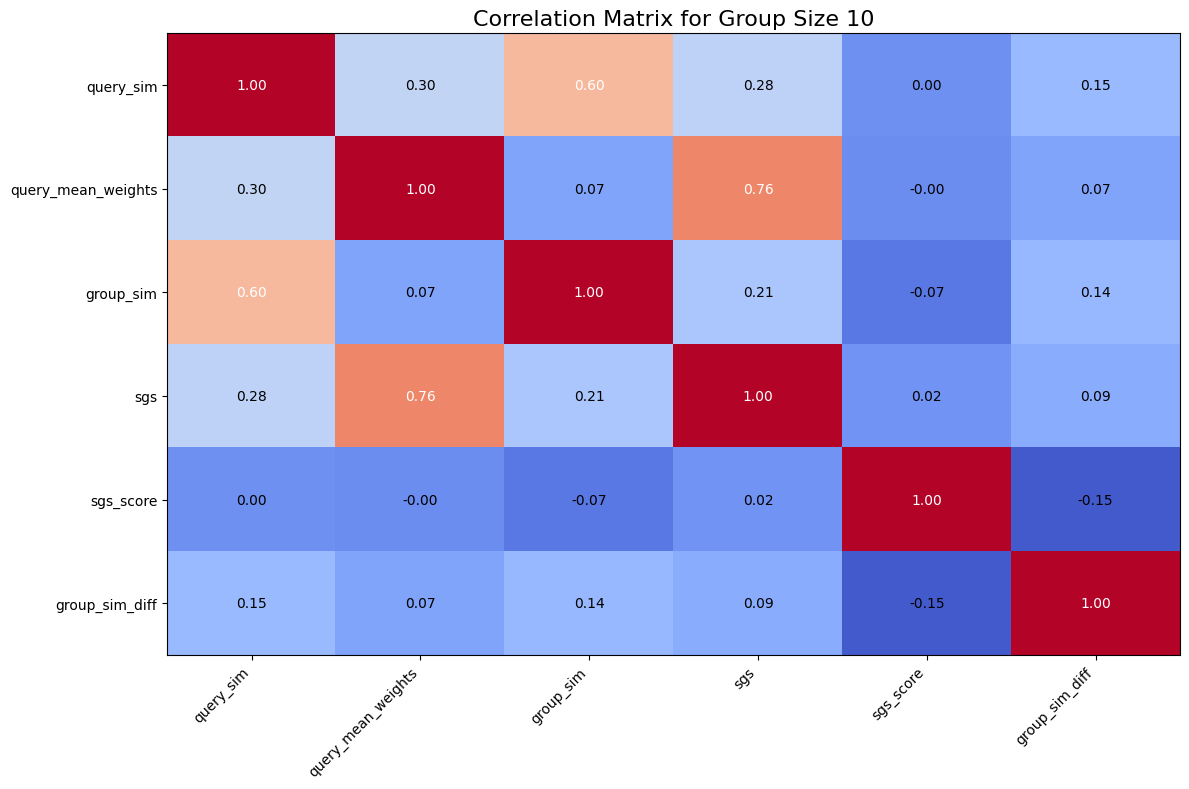

In [17]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import numpy as np

def create_correlation_matrices_animation():
    """
    Create an animated correlation matrix heatmap showing how correlations change
    across different group sizes.
    """
    # Get the columns to correlate (excluding 'analogue_ids')
    columns_to_correlate = ["query_sim", "query_mean_weights", "group_sim", "sgs", "sgs_score", "group_sim_diff"]
    
    # Find global min/max correlation values for consistent color scaling
    all_correlations = []
    for df in all_dfs:
        corr_matrix = df[columns_to_correlate].corr()
        all_correlations.extend(corr_matrix.values.flatten())
    
    global_vmin = min(all_correlations)
    global_vmax = max(all_correlations)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    def update(frame):
        ax.clear()
        
        # Get current dataframe and group size
        df = all_dfs[frame].drop(columns=["analogue_ids"])
        group_size = frame + 2  # Group sizes start at 2
        
        # Calculate correlation matrix
        corr_matrix = df[columns_to_correlate].corr()
        
        # Create heatmap using matplotlib
        im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto', 
                      vmin=global_vmin, vmax=global_vmax)
        
        # Set ticks and labels
        ax.set_xticks(range(len(corr_matrix.columns)))
        ax.set_yticks(range(len(corr_matrix.index)))
        ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
        ax.set_yticklabels(corr_matrix.index)
        
        # Add correlation values as text
        for i in range(len(corr_matrix.index)):
            for j in range(len(corr_matrix.columns)):
                color = "white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black"
                ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color=color, fontsize=10)
        
        # Set title
        ax.set_title(f"Correlation Matrix for Group Size {group_size}", fontsize=16)
        
        plt.tight_layout()
        
        return [im]
    
    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(all_dfs), 
                                 blit=False, interval=1000)
    
    # Save as gif
    gif_filename = 'correlation_matrices_by_group_size.gif'
    ani.save(gif_filename, writer=PillowWriter(fps=1))
    
    print(f"Animation saved as {gif_filename}")
    
    # Display the gif in the notebook
    from IPython.display import Image, display
    return Image(filename=gif_filename)

# Create the animation
animation_image = create_correlation_matrices_animation()
animation_image

analogue_df.group_sim.hist(bins=100, range=(xmin, xmax))